# ESMO Open Conference Researcher Knowledge Base
## Multi-modal RAG with Amazon Bedrock Knowledge Bases

### Purpose
Amazon Bedrock Knowledge Bases provides a comprehensive, end-to-end managed Retrieval-Augmented Generation (RAG) solution that enables organizations to develop accurate, responsive, secure, and customized generative AI applications by integrating contextual information from their proprietary data sources.

This notebook demonstrates multi-modal RAG capabilities, allowing systems to analyze and extract insights from both textual and visual content, including images, charts, diagrams, and tables. RAG uses abstracts from ESMO Open (European Society for Medical Oncology's open-access journal) to show how an integration with a major oncology conference like ESMO Open datacan enhance the large language models' ability to provide oncology research findings with appropreate reference citing.

This expanded functionality works by:

- Extracting content from diverse data formats (both textual and visual)
- Generating semantic embeddings via Amazon Titan Embedding model
- Storing these embeddings in the designated vector database. Amazon OpeanSearch Serverless
- Enabling retrieval and answer generation based on the combined data sources, including ESMO Open publications
- A key enhancement is the inclusion of source attribution for visual data in retrieved results, which improves transparency and strengthens user confidence in the generated outputs, particularly important for medical and scientific information sourced from ESMO Open.

### Steps
1. Create Knowledge Base execution role with necessary policies for accessing/writing data from/to S3 and required Foundation models .
2. Create a knowledge base with rich content documents
3. Create data source(s) within knowledge base
4. Start ingestion jobs using KB APIs which which will read data from the data source, parse the documents (images, charts, tables etc.)using Bedrock Data Automation or Foundation model, chunk it, convert chunks into embeddings using Amazon Titan Embeddings model and then store these embeddings in AOSS. All of this without having to build, deploy and manage the data pipeline.

### Data Source
>ESMO Open is the European Society for Medical Oncology's online-only, peer-reviewed open access journal, dedicated to publishing high-quality medical research and educational content from all disciplines of oncology, with a focus on innovative clinical and translational cancer research. The Journal aims to maximize industry networks to curate and disseminate preclinical or translational data. We hope to bridge the gap between basic research and clinical applications, facilitating the translation of groundbreaking discoveries into tangible advancements in cancer care. Our platform will serve as a catalyst for innovation, nurturing the dialogue between academia, industry, and clinical practice.
[ESMO Open](https://www.esmoopen.com/)

### Pre-requisites
Please make sure to enable Anthropic Claude 3 Sonnet 3.5 , Amazon Nova Micro and Titan Text Embeddings V2 model access in Amazon Bedrock Console

### RAG Architecture 
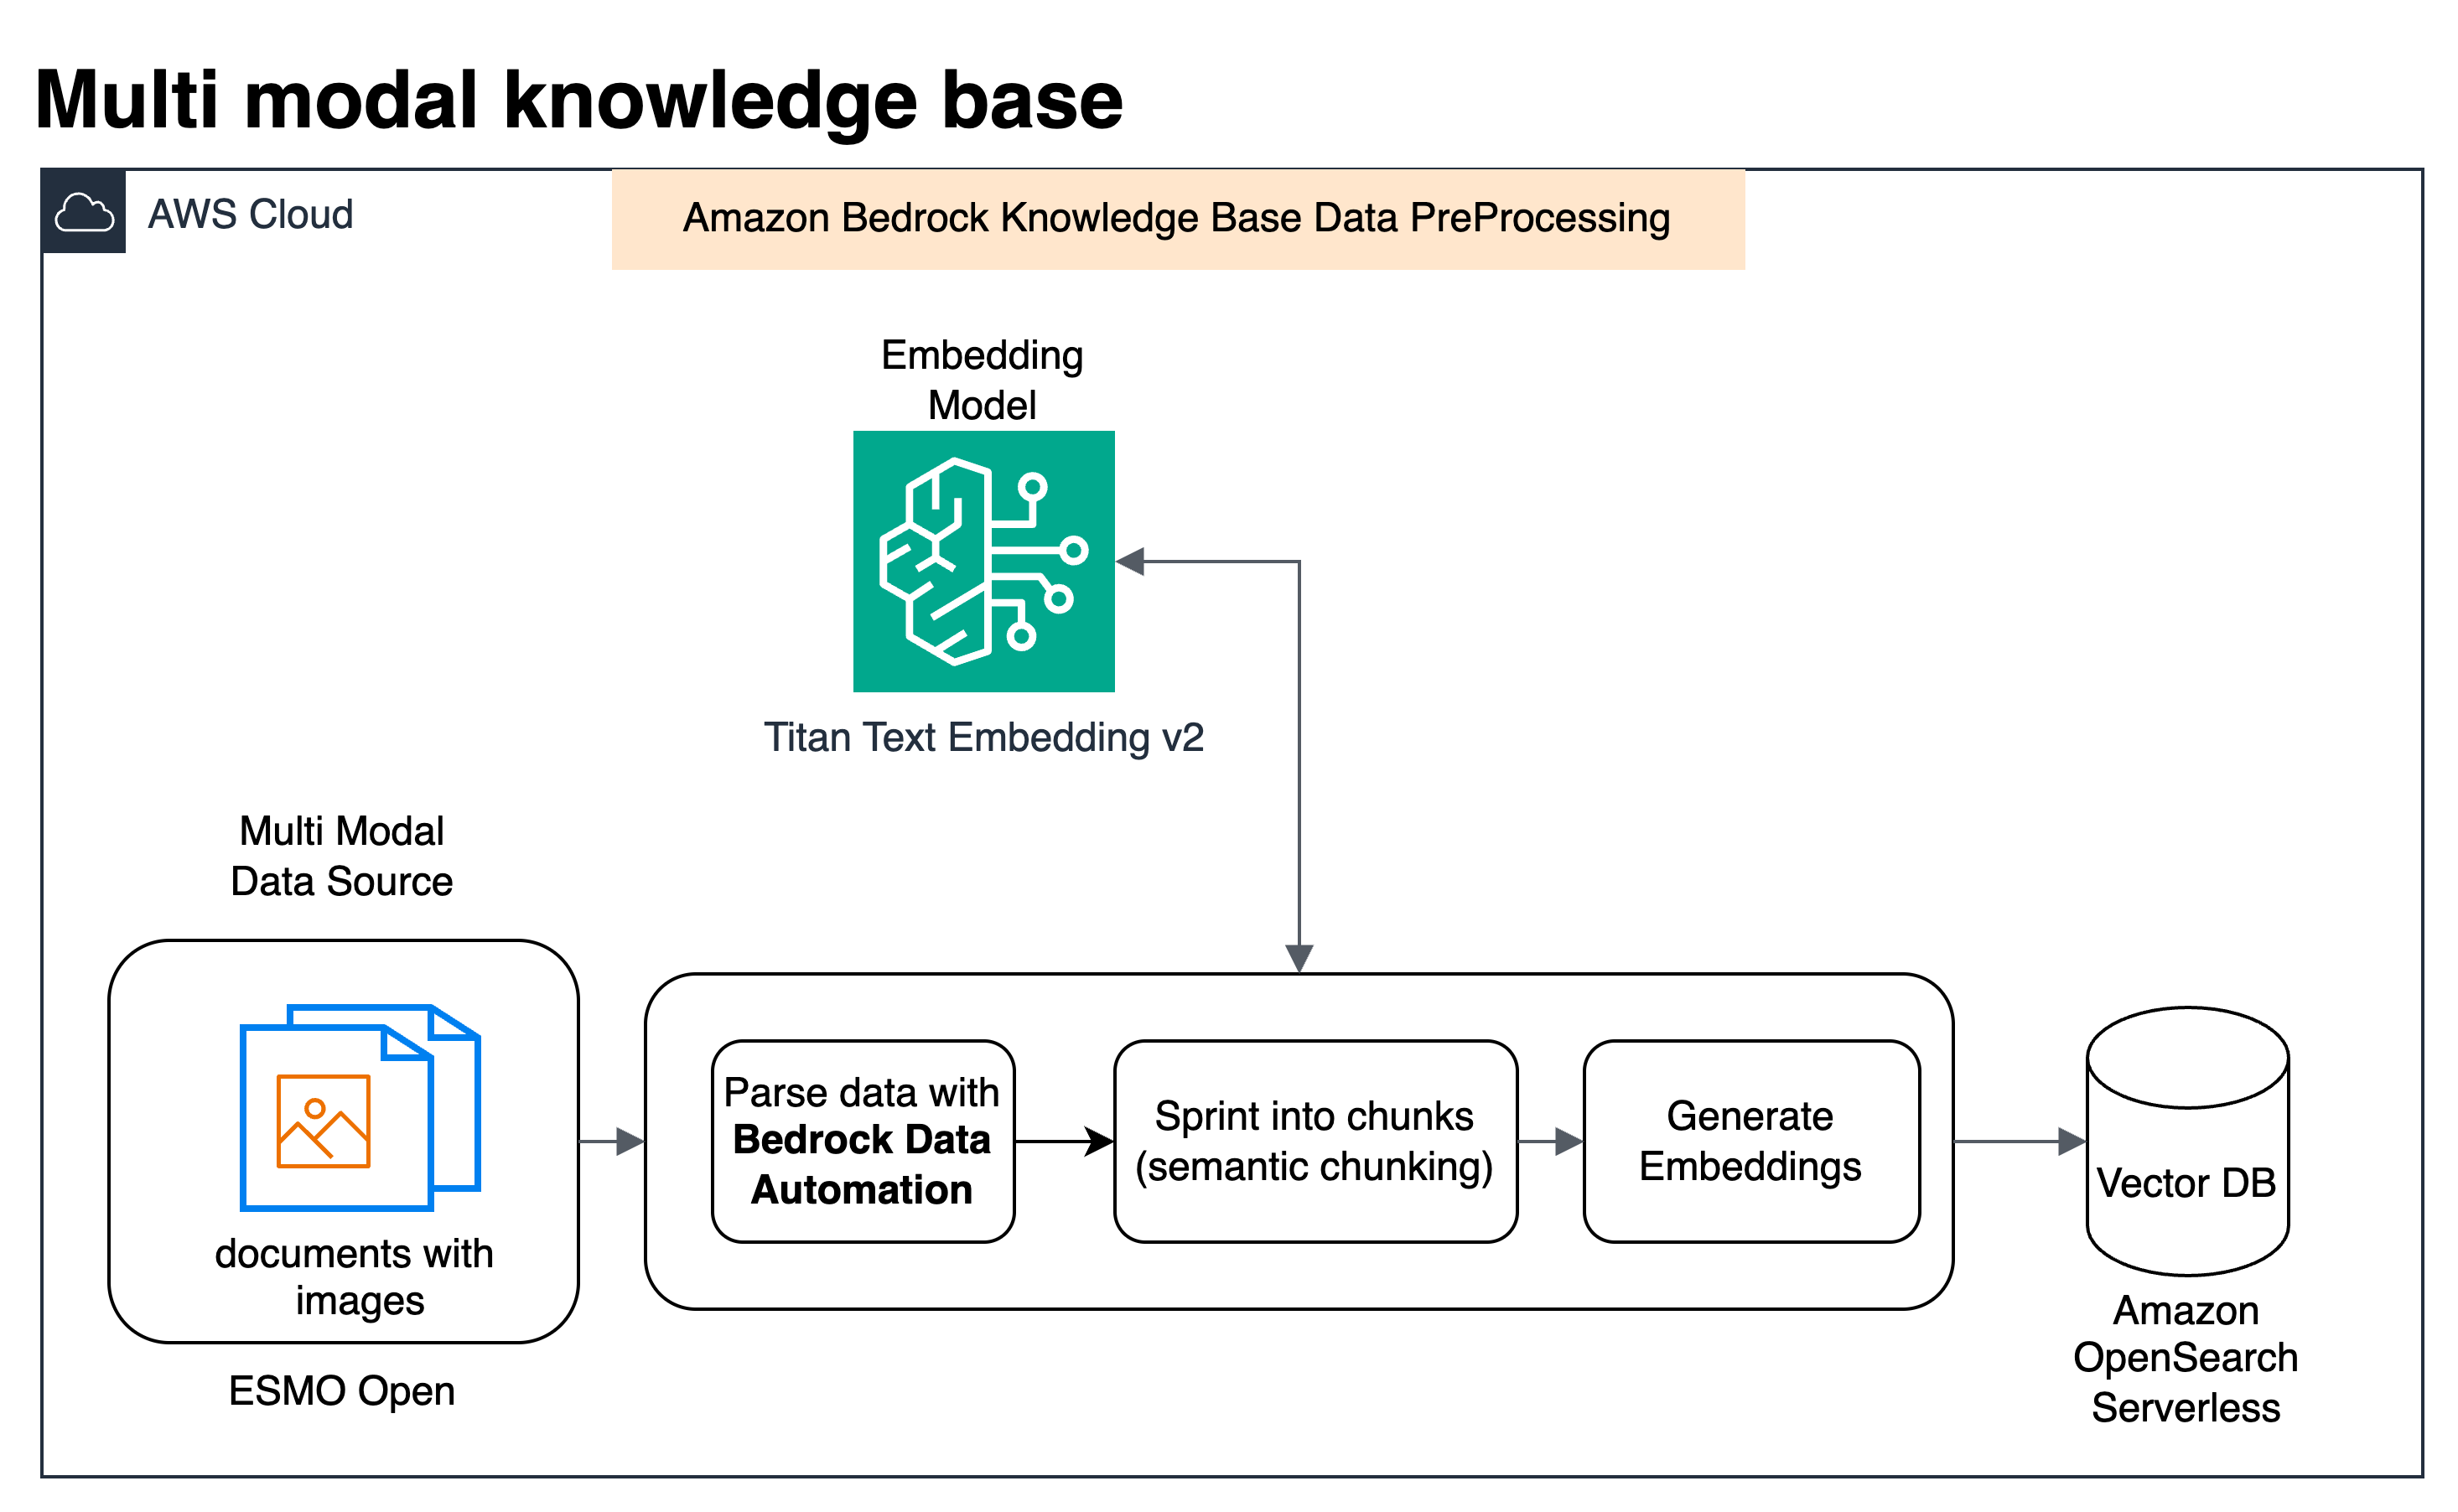

## Setup Workspace

In [ ]:
# upgrade boto3 
%pip install --upgrade pip --quiet
%pip install boto3 --upgrade --quiet


!pip install --upgrade -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### IAM Policy Set Up

Bedrock Full Access to the execution role. 


## Import libraries

In [15]:
import json
import os
import boto3
from datetime import datetime
from botocore.exceptions import ClientError
from utils.knowledge_base import BedrockKnowledgeBase


## Set up access to your AWS account

In [ ]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 
#logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
#logger = logging.getLogger(__name__)
region, account_id

## Knowledge base config

In [17]:
import time

# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name = f"esmo-open-kb-{suffix}"
knowledge_base_description = "ESMO Open Conference Abtracts from 2025"

bucket_name = f'data-{knowledge_base_name}'
foundation_model = "anthropic.claude-3-5-sonnet-20240229-v1:0"

# Create a bucket in Amazon S3

In [18]:
#Create a bucket in S3
data_sources=[
                {"type": "S3", "bucket_name": bucket_name}
            ]

## Create Amazon Bedrock Knowlege Base

! This might take a few minumtes to run. 

Since we would like to create embedding for both text and images, given in the abstracts, we need to parse the documents with either Bedrock Data Automation or LLM. 

The code snippet below uses Bedrock Data Automation tp parse multi modal data and semantic chunking.  Semantic chunking divides the text into meaningful chunks, instead of just syntactic structure. 
1. `multi_modal= True ` 
2. `parser='BEDROCK_DATA_AUTOMATION' `
3. `chunking_strategy='SEMANTIC `

In [19]:
knowledge_base = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name}',
    kb_description=knowledge_base_description,
    data_sources=data_sources,
    multi_modal= True,
    #parser='BEDROCK_FOUNDATION_MODEL',
    parser='BEDROCK_DATA_AUTOMATION',
    #chunking_strategy = "FIXED_SIZE", 
    chunking_strategy='SEMANTIC',
    suffix = f'{suffix}-f'
)


Step 1 - Creating or retrieving S3 bucket(s) for Knowledge Base documents
['data-esmo-open-kb-3115243', 'esmo-open-kb-3115243-intermediate-3115243-f']
buckets_to_check:  ['data-esmo-open-kb-3115243', 'esmo-open-kb-3115243-intermediate-3115243-f']
Creating bucket data-esmo-open-kb-3115243
Creating bucket esmo-open-kb-3115243-intermediate-3115243-f
Step 2 - Creating Knowledge Base Execution Role (AmazonBedrockExecutionRoleForKnowledgeBase_3115243-f) and Policies
Step 3a - Creating OSS encryption, network and data access policies
Step 3b - Creating OSS Collection (this step takes a couple of minutes to complete)
{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '320',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Tue, 13 May 2025 10:56:04 '
                                                 'GMT',
                           

## Upload data to the S3 bucket
1. Download the data from ./esmo-open-abstracts in your project directory
2. Upload to your S3 bucket (given in `data_bucket_name`)

In [20]:
def upload_directory(path, bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                file_to_upload = os.path.join(root,file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload,bucket_name,file)

upload_directory("esmo-open-abstracts", bucket_name)

uploading file esmo-open-abstracts/Quality-adjusted-survival-in-patients-with-metasta.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Palbociclib-exposure-in-relation-to-efficacy-and-t.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/First-in-human-phase-I-study-to-evaluate-safety-t.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/A-phase-I-first-in-human-trial-of-KO-947-an-ERK1.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Adjuvant-immunotherapy-in-the-modern-management-of.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Integrating-radiomics-pathomics-and-biopsy-adapt.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Integrated-clinico-molecular-analysis-of-gastric-c.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Transarterial-chemoembolisation-with-irinotecan-(i.pdf to data-esmo-open-kb-3115243
uploading file esmo-open-abstracts/Early-CTLA4-increa

## Data Ingestion

Start the ingestion job for each data source. During ingestion:
1. fetch the documents from the data source
2. parse the document to extract text and images
3. chunk it smaller sizes based on the chunking strategy
4. create an embedding (vector database) for each chunk
5. As an embedding models, I am using `Amazon Titan Text Embeddingsv2`
5. write to the vector database. In this notebook, I am usign Amazon OpenSearch Serverless vector db

In [24]:
# ensure that the kb is available
time.sleep(30)
try:
    response = knowledge_base.start_ingestion_job() # sync knowledge base
    job_id = response['ingestionJobId']
    
    # Monitor the job status
    while True:
        status = knowledge_base.get_ingestion_job(ingestionJobId=job_id)
        if status['status'] in ['FAILED', 'COMPLETED']:
            print(f"Job finished with status: {status['status']}")
            if status['status'] == 'FAILED':
                print(f"Failure reason: {status.get('failureReason')}")
            break
        time.sleep(30)
except Exception as e:
    print(f"Error during ingestion: {str(e)}")


job 1 started successfully

{ 'dataSourceId': 'AWRNRP5J8U',
  'ingestionJobId': 'G2ITEHTZDE',
  'knowledgeBaseId': 'JKAFUIQUDV',
  'startedAt': datetime.datetime(2025, 5, 13, 14, 34, 13, 984592, tzinfo=tzutc()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 14,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 14},
  'status': 'COMPLETE',
  'updatedAt': datetime.datetime(2025, 5, 13, 14, 40, 13, 901582, tzinfo=tzutc())}
Error during ingestion: 'NoneType' object is not subscriptable


## Manually synch your data source
1. Go to AWs Console > Bedrock > Knowledge Bases
2. Locate your KB
3. Go to Data source
4. Sync the data source

In [ ]:
# keep the kb_id for invocation later in the invoke request
kb_id = knowledge_base.get_knowledge_base_id()
%store kb_id

# Test your knowledge base

In [26]:
prompt = "What is the current status of adjuvant immunotherapy for resected melanoma?"

foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
# foundation_model = "amazon.nova-micro-v1:0"

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": prompt
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

Adjuvant immunotherapy with anti-PD-1 drugs nivolumab and pembrolizumab is currently approved by the European Medicines Agency (EMA) for patients with resected stage III and IV (nivolumab only) melanoma since 2018-2019. More recently in 2022-2023, these drugs were also approved for resected stage IIB/C melanoma, broadening the scope of adjuvant immunotherapy in selected European countries. The rationale for offering adjuvant anti-PD-1 immunotherapy is supported by data showing significant improvements in recurrence-free survival (RFS) and distant metastasis-free survival (DMFS), with around 40% relative reduction in the risk of recurrence or death compared to placebo. However, there remains uncertainty regarding the overall survival (OS) benefit due to lack of direct evidence from phase III trials for improved OS with adjuvant immunotherapy at any stage.



## Clean up

In [ ]:
# # Delete resources
# print("===============================Deleteing resources ==============================\n")
knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True)